<a href="https://colab.research.google.com/github/down-shift/license-plate-recognition/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Olymps/droneshub

/content/drive/MyDrive/Olymps/droneshub


In [ ]:
!apt install tesseract-ocr-eng
!pip install pytesseract 
!wget https://github.com/tesseract-ocr/tessdata/raw/main/eng.traineddata
!gunzip eng.traineddata
!sudo mv -v eng.traineddata /usr/share/tesseract-ocr/4.00/tessdata

In [ ]:
!pip install -U opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.9 MB 1.1 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# !wget https://raw.githubusercontent.com/spmallick/mallick_cascades/master/haarcascades/haarcascade_russian_plate_number.xml

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import gc
import json
import glob
# import pytesseract
import re
import PIL
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns


from google.colab.patches import cv2_imshow
from matplotlib.path import Path
from torchvision import models
from torchvision import transforms
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
from numba import njit, jit

torch.jit.enable_onednn_fusion(True)

In [ ]:
# Constants.
INPUT_WIDTH = 640
INPUT_HEIGHT = 640
SCORE_THRESHOLD = 0.5
NMS_THRESHOLD = 0.45
CONFIDENCE_THRESHOLD = 0.45

# Text parameters.
FONT_FACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1

# Colors.
BLACK  = (0,0,0)
BLUE   = (230,150,50)
YELLOW = (0,255,255)

# Распознавание с CRNN

In [ ]:
OOV_TOKEN = '<OOV>'
CTC_BLANK = '<BLANK>'


def get_char_map(alphabet):
    char_map = {value: idx + 2 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    char_map[OOV_TOKEN] = 1
    return char_map


class Tokenizer:
    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else self.char_map[OOV_TOKEN]
                 for char in word]
            )
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                if (
                    char_enc != self.char_map[OOV_TOKEN]
                    and char_enc != self.char_map[CTC_BLANK]
                    and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

In [ ]:
def get_resnet34_backbone():
    m = models.resnet34(pretrained=True)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu,
              m.maxpool, m.layer1, m.layer2, m.layer3]
    return nn.Sequential(*blocks)


class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out


class CRNN(nn.Module):
    def __init__(
        self, number_class_symbols, time_feature_count=256, lstm_hidden=256,
        lstm_len=2,
    ):
        super().__init__()
        self.feature_extractor = get_resnet34_backbone()
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (time_feature_count, time_feature_count))
        self.bilstm = BiLSTM(time_feature_count, lstm_hidden, lstm_len)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, time_feature_count),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(time_feature_count, number_class_symbols)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.bilstm(x)
        x = self.classifier(x)
        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)
        return x

In [ ]:
class Resize(object):
    def __init__(self, size=(250, 50)):
        self.size = size

    def __call__(self, img):
        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img


class Normalize:
    def __call__(self, img):
        img = img.astype(np.float32) / 255
        return img

In [ ]:
class InferenceTransform:
    def __init__(self):
        self.transforms = transforms.Compose([
            Resize(size=(250, 50)),
            Normalize(),
            transforms.ToTensor()
        ])

    def __call__(self, images):
        transformed_images = []
        for image in images:
            image = self.transforms(image)
            transformed_images.append(image)
        transformed_tensor = torch.stack(transformed_images, 0)
        return transformed_tensor


class Predictor:
    def __init__(self, model_path, device=torch.device('cpu')):
        self.tokenizer = Tokenizer(ALPHABET)
        self.device = torch.device(device)
        # load model
        self.model = CRNN(number_class_symbols=self.tokenizer.get_num_chars())
        self.model.load_state_dict(torch.load(model_path, map_location=device))
        self.model.to(self.device)

        self.transforms = InferenceTransform()

    def __call__(self, images):
        if isinstance(images, (list, tuple)):
            one_image = False
        elif isinstance(images, np.ndarray):
            images = [images]
            one_image = True
        else:
            raise Exception(f"Input must contain np.ndarray, "
                            f"tuple or list, found {type(images)}.")

        images = self.transforms(images)
        pred = predict(images, self.model, self.tokenizer, self.device)

        if one_image:
            return pred[0]
        else:
            return pred

In [ ]:
def predict(images, model, tokenizer, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    return text_preds

In [ ]:
classes = ['plate']
img_path = '/content/drive/MyDrive/Olymps/droneshub/yolov5/russian-car-plates-3/valid/images/'
yolo_path = '/content/drive/MyDrive/Olymps/droneshub/yolov5/runs/train/plates_yolo3/weights/best.onnx'
ocr_path = '/content/drive/MyDrive/Olymps/droneshub/model-7-0.9156.ckpt'
ALPHABET = '0123456789ABEKMHOPCTYX'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
predictor = Predictor(ocr_path)
device

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

device(type='cpu')

In [ ]:
def draw_label(im, label, x, y):
    text_size = cv2.getTextSize(label, FONT_FACE, FONT_SCALE, THICKNESS)
    dim, baseline = text_size[0], text_size[1]
    cv2.rectangle(im, (x,y), (x + dim[0], y + dim[1] + baseline), BLUE, cv2.FILLED);
    cv2.putText(im, label, (x, y + dim[1]), FONT_FACE, FONT_SCALE, (255, 255, 255), THICKNESS, cv2.LINE_AA)


def pre_process(input_image, net):
    blob = cv2.dnn.blobFromImage(input_image, 1/255,  (INPUT_WIDTH, INPUT_HEIGHT), [0,0,0], 1, crop=False)
    net.setInput(blob)
    outputs = net.forward(net.getUnconnectedOutLayersNames())
    return outputs


def detect_plate(input_image, outputs, predictor):
    class_ids = []
    confidences = []
    boxes = []
    rows = outputs[0].shape[1]
    image_height, image_width = input_image.shape[:2]
    x_factor = image_width / INPUT_WIDTH
    y_factor =  image_height / INPUT_HEIGHT
    for r in range(rows):
          row = outputs[0][0][r]
          confidence = row[4]
          if confidence >= CONFIDENCE_THRESHOLD:
                classes_scores = row[5:]
                class_id = np.argmax(classes_scores)
                if (classes_scores[class_id] > SCORE_THRESHOLD):
                      confidences.append(confidence)
                      class_ids.append(class_id)
                      cx, cy, w, h = row[0], row[1], row[2], row[3]
                      left = int((cx - w/2) * x_factor)
                      top = int((cy - h/2) * y_factor)
                      width = int(w * x_factor)
                      height = int(h * y_factor)
                      box = np.array([left, top, width, height])
                      boxes.append(box)
    indices = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)
    for cnt, i in enumerate(indices):
          box = boxes[i]
          left = box[0]
          top = box[1]
          width = box[2]
          height = box[3]             
          cv2.rectangle(input_image, (left, top), (left + width, top + height), BLUE, 3*THICKNESS)
          ret, plate = cv2.threshold(cv2.resize(input_image[top:top + height, left:left + width], (500, 120)), 100, 255, cv2.THRESH_BINARY)
          label = predictor(cv2.resize(input_image[top:top + height, left:left + width], (500, 120)))
          # label = predictor(plate)
          r = re.compile(r'[\W_]+')
          label = r.sub('', label)  # оставить в строке только цифры и буквы
          print(label)
          print((left, top), (left + width, top + height))
          draw_label(input_image, label, left - 1, top - 22)
    return input_image

In [ ]:
# with open(cfg_file_name, 'w') as cfg:
#     with open(yaml_file_name,'r') as f:
#         f = yaml.load(f,Loader=yaml.FullLoader)
#         net = 0
#         for l in f:
#             if ((l != 'anchors')and(l !='backbone')and(l !='head')):
#                 if net == 0:
#                     cfg.write('\n[net]\n')
#                     cfg.write("width={}\n".format(416))
#                     cfg.write("height={}\n".format(416))
#                     cfg.write("channels={}\n".format(3))
#                     net =1
#                 cfg.write("{}={}\n".format(l,f[l]))
#             elif (l == 'anchors'):
#                 anchors = []
#                 for v in f[l]:
#                     anchors.extend(v)
#                 cfg.write("anchors={}\n".format(str(anchors)[1:-1]))
#             elif((l == 'backbone') or (l =='head')): 
#                 for vector in f[l]:
#                     #net type
#                     cfg.write('\n[{}]\n'.format(vector[2]))
#                     #from
#                     if type(vector[0]) == int:
#                         cfg.write("from={}\n".format(str(vector[0])))
#                     elif type(vector[0]) == list:
#                         cfg.write("from={}\n".format(str(vector[0])[1:-1]))
#                     #number
#                     if type(vector[1]) == int:
#                         cfg.write("number={}\n".format(str(vector[1])))
#                     elif type(vector[1]) == list:
#                         cfg.write("number={}\n".format(str(vector[1])[1:-1]))
#                     #params
#                     if type(vector[3]) == int:
#                         cfg.write("args={}\n".format(str(vector[3])))
#                     elif type(vector[3]) == list:
#                         cfg.write("args={}\n".format(str(vector[3])[1:-1]))

In [ ]:
frame = cv2.imread(img_path + os.listdir(img_path)[21])
net = cv2.dnn.readNet(yolo_path)
detections = pre_process(frame, net)
img = detect_plate(frame.copy(), detections, predictor)
t, _ = net.getPerfProfile()
label = 'YOLOv5 inference time: %.2f ms' % (t * 1000.0 /  cv2.getTickFrequency())
print(label)
cv2_imshow(img)

error: ignored

In [ ]:
%%time
frame = cv2.imread(img_path + os.listdir(img_path)[22])
img = detect_plate(frame.copy(), detections, predictor)

M556HT34
(752, 374) (851, 405)
CPU times: user 264 ms, sys: 2.42 ms, total: 266 ms
Wall time: 839 ms


# Распознавание с Tesseract

In [ ]:
cfg = '-c tessedit_char_whitelist=0123456789ABEKMHOPCTYX --psm 8 --oem 2'
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

def decodenum(number_img, cfg):
    res = pytesseract.image_to_string(number_img, config=cfg)
    return res

sosro2
(425, 521) (677, 629)
Inference time: 647.01 ms


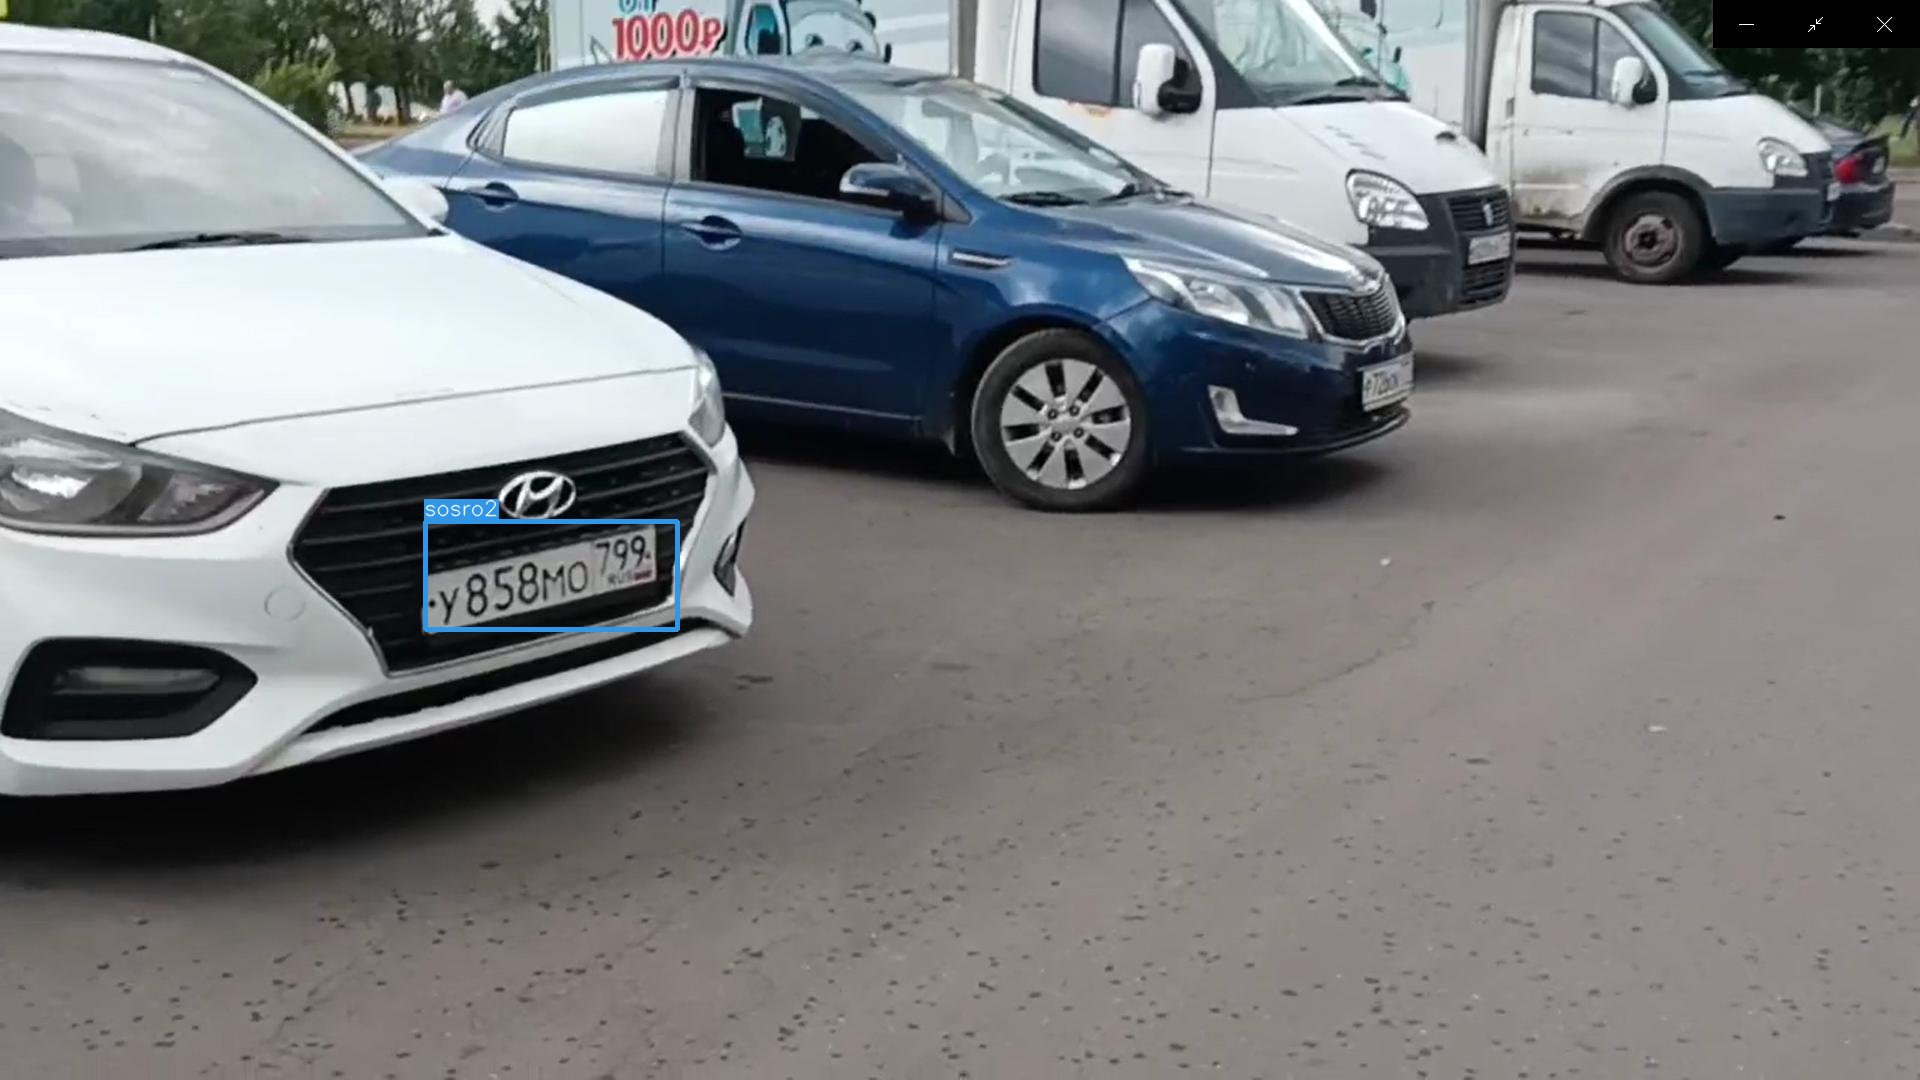

In [ ]:
classes = ['plate']
path = '/content/drive/MyDrive/Olymps/droneshub/yolov5/russian-car-plates-3/valid/images/'
frame = cv2.imread(path + os.listdir(path)[-3])
modelWeights = '/content/drive/MyDrive/Olymps/droneshub/yolov5/runs/train/plates_yolo3/weights/best.onnx'
net = cv2.dnn.readNet(modelWeights)
# Process image.
detections = pre_process(frame, net)
img = post_process(frame.copy(), detections)
t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 /  cv2.getTickFrequency())
print(label)
cv2_imshow(img)

In [ ]:
def cutout(image, contour):
    pts = np.float32([contour[0][0], contour[3][0], contour[1][0], contour[2][0]][::-1])
    pts2 = np.float32([[0, 0], [500, 0], [0, 140], [500, 140]][::-1])
    M = cv2.getPerspectiveTransform(pts, pts2)
    dst = cv2.warpPerspective(image, M, (500, 140))
    return dst

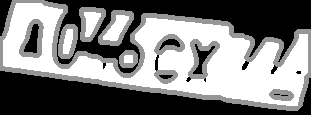

In [ ]:
cv2_imshow(cv2.drawContours(opening.copy(), contours, -1, (150,150,150), 3))

In [ ]:
sample = frame[335:450, 1194:1505]
k = 13  # kernel
sample = cv2.GaussianBlur(sample, (k, k), 3)
ret, gray = cv2.threshold(cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY),100,255,cv2.THRESH_BINARY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 7))
opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
contours, hierarchy = cv2.findContours(closing.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
epsilon = 0.07 * cv2.arcLength(contours[4], True)
rect = cutout(sample, cv2.approxPolyDP(contours[4], epsilon, True))
cv2_imshow(rect)

IndexError: ignored

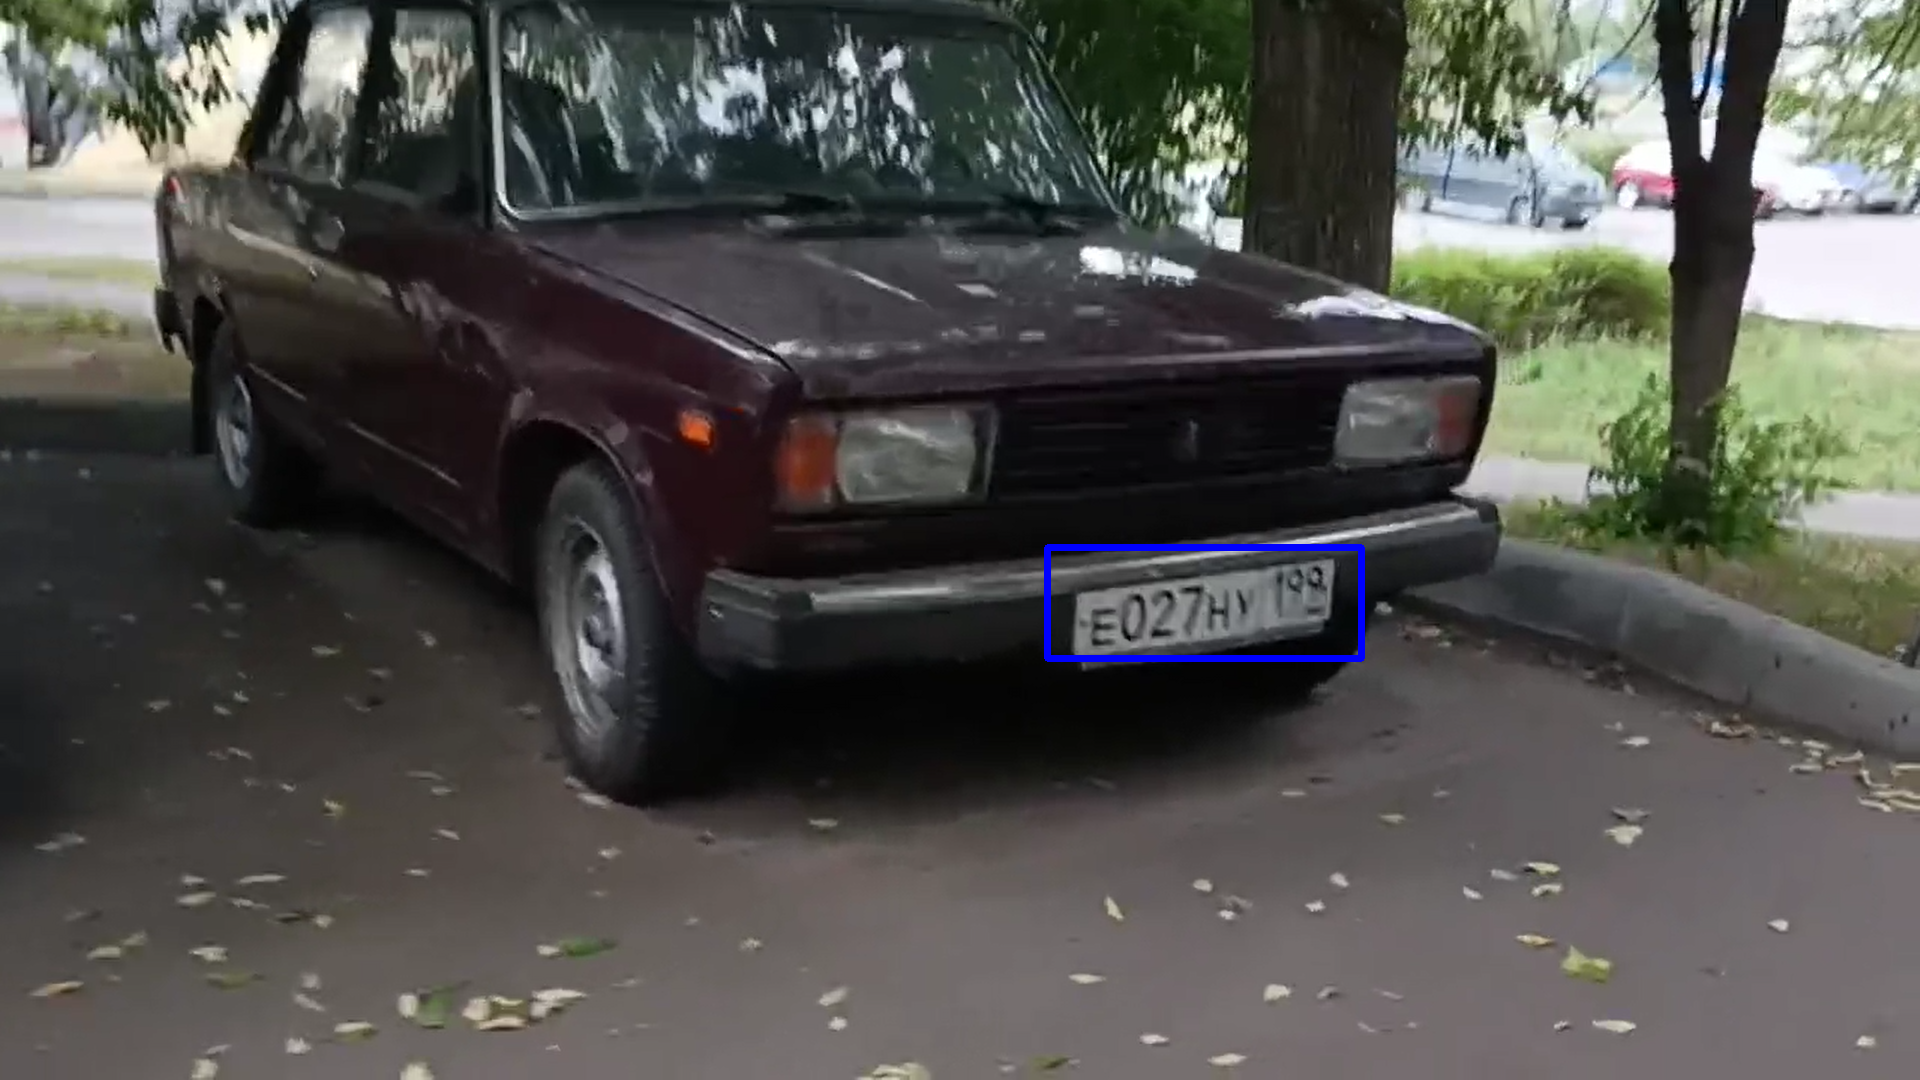

['  503 7 0 613\n\x0c']


In [ ]:
img = cv2.imread('/content/Снимок экрана (725).png')
img_overlay = img.copy()
carplate_rects = carplate_haar_cascade.detectMultiScale(img, scaleFactor=1.5, minNeighbors=4)
numbers = []
numbers_decode = []

for x,y,w,h in carplate_rects: 
    cv2.rectangle(img_overlay, (x-5,y-5), (x+w+5,y+h+5), (255,0,0), 5)
    carplate_img = img[y:y+h-3, x:x+w]
    ret,thresh_bin = cv2.threshold(carplate_img,60,255,cv2.THRESH_BINARY)
    # cv2.imwrite('num_out.jpg', cv2.resize(thresh_bin, (w*3,h*3)))
    numbers.append(carplate_img) 
    numbers_decode.append(decodenum(cv2.resize(carplate_img, (300, 200)), cfg))

cv2_imshow(img_overlay)
# cv2.imwrite('out.jpg', img_overlay)
print(numbers_decode)

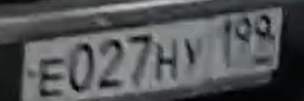

In [ ]:
cv2_imshow(cv2.resize(carplate_img, (w, h)))

In [ ]:
def verify(s):
    if ((s[:2].isalpha() and s[2:5].isnum() and s[5:7].isalpha() and s[7:].isnum()) or   # обычные номера
       (s[:2].isalpha() and s[2:].isnum())):  # номера грузовиков 
        return True
    else:
        return False

In [ ]:
def draw_label(im, label, x, y):
    """Draw text onto image at location."""
    # Get text size.
    text_size = cv2.getTextSize(label, FONT_FACE, FONT_SCALE, THICKNESS)
    dim, baseline = text_size[0], text_size[1]
    # Use text size to create a BLACK rectangle.
    cv2.rectangle(im, (x,y), (x + dim[0], y + dim[1] + baseline), BLUE, cv2.FILLED);
    # Display text inside the rectangle.
    cv2.putText(im, label, (x, y + dim[1]), FONT_FACE, FONT_SCALE, (255, 255, 255), THICKNESS, cv2.LINE_AA)


def pre_process(input_image, net):
    # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(input_image, 1/255,  (INPUT_WIDTH, INPUT_HEIGHT), [0,0,0], 1, crop=False)
    # Sets the input to the network.
    net.setInput(blob)
    # Run the forward pass to get output of the output layers.
    outputs = net.forward(net.getUnconnectedOutLayersNames())
    return outputs


def post_process(input_image, outputs):
    # Lists to hold respective values while unwrapping.
    class_ids = []
    confidences = []
    boxes = []
    # Rows.
    rows = outputs[0].shape[1]
    image_height, image_width = input_image.shape[:2]
    # Resizing factor.
    x_factor = image_width / INPUT_WIDTH
    y_factor =  image_height / INPUT_HEIGHT
    # Iterate through detections.
    for r in range(rows):
          row = outputs[0][0][r]
          confidence = row[4]
          # Discard bad detections and continue.
          if confidence >= CONFIDENCE_THRESHOLD:
                classes_scores = row[5:]
                # Get the index of max class score.
                class_id = np.argmax(classes_scores)
                #  Continue if the class score is above threshold.
                if (classes_scores[class_id] > SCORE_THRESHOLD):
                      confidences.append(confidence)
                      class_ids.append(class_id)
                      cx, cy, w, h = row[0], row[1], row[2], row[3]
                      left = int((cx - w/2) * x_factor)
                      top = int((cy - h/2) * y_factor)
                      width = int(w * x_factor)
                      height = int(h * y_factor)
                      box = np.array([left, top, width, height])
                      boxes.append(box)
    # Perform non maximum suppression to eliminate redundant, overlapping boxes with lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)
    for cnt, i in enumerate(indices):
          box = boxes[i]
          left = box[0]
          top = box[1]
          width = box[2]
          height = box[3]             
          # Draw bounding box.             
          cv2.rectangle(input_image, (left, top), (left + width, top + height), BLUE, 3*THICKNESS)
          ret, plate = cv2.threshold(cv2.resize(input_image[top:top + height, left:left + width], (500, 120)), 100, 255, cv2.THRESH_BINARY)
          # ret,thresh_bin = cv2.threshold(carplate_img,60,255,cv2.THRESH_BINARY)
          label = decodenum(plate, cfg) 
          r = re.compile(r'[\W_]+')
          label = r.sub('', label)  # оставить в строке только цифры и буквы
          print(label)
          print((left, top), (left + width, top + height))
          # label = "{}:{:.2f}".format('plate', confidences[i])             
          draw_label(input_image, label, left - 1, top - 22)
    return input_image